# Исследование поведения пользователей сервиса для покупки продуктов

Для стартапа, который продаёт продукты питания, нужно проанализировать поведение пользователей мобильного приложения. Есть данные о  каждом событии - название, ID пользователя, время и номер эксперимента (пользователи поделены на группы -  246 и 247 — контрольные группы, а 248 — экспериментальная). На пользователях экспериментальной группы разработчики тестируют новый шрифт.

Задачи:

- изучить воронку продаж
- оценить результаты A/A/B-эксперимента: сравнить сначала контрольные группы, а затем объединённую контрольную группу с группой с изменённым шрифтом

In [1]:
import pandas as pd
import numpy as np
import math as mth
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from plotly import graph_objects as go

## Загрузка данных

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
display(df.head())
df.info()

print('Количество строк-дубликатов:', df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)

df.shape

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
Количество строк-дубликатов: 413


(243713, 4)

## Подготовка данных

In [3]:
# переименуем столбцы

df.columns = ['event_name', 'user_id', 'event_timestamp', 'exp_id']

In [4]:
# проверка на пропуски

df.isna().sum()

event_name         0
user_id            0
event_timestamp    0
exp_id             0
dtype: int64

In [5]:
# новые стобцы с датой и временем и отдельно датой

df['date_time'] = pd.to_datetime(df['event_timestamp'], unit='s')
df['date'] = df['date_time'].astype('datetime64[D]')

df.head()

,event_name,user_id,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [6]:
# проверка групп на пересечения

mask = df.loc[df['exp_id']==246, 'user_id'].isin(df.loc[df['exp_id']==247])
mask1 = df.loc[df['exp_id']==246, 'user_id'].isin(df.loc[df['exp_id']==248])
mask2 = df.loc[df['exp_id']==247, 'user_id'].isin(df.loc[df['exp_id']==248])
res = df.drop(mask[mask].index)
res = res.drop(mask1[mask1].index)
res = res.drop(mask2[mask2].index)
res.shape

print('Количество пересечений:', df.shape[0] - res.shape[0])

Количество пересечений: 0


## Изучение и проверка данных 

In [9]:
df.describe()

,user_id,event_timestamp,exp_id
count,2.437130e+05,2.437130e+05,243713.000000
mean,4.627963e+18,1.564914e+09,247.022161
std,2.642723e+18,1.771388e+05,0.824420
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: user_id, dtype: float64


(0.0, 500.0)

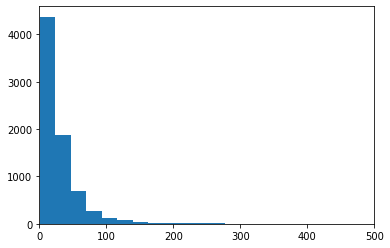

In [24]:
count = df['user_id'].value_counts()
print(count.describe())
plt.hist(count, bins=100)
plt.xlim(left=0, right=500)

In [26]:
print(np.percentile(count, 95))
print(np.percentile(count, 99))

89.0
200.5


Есть пользователи, которые совершали очень много событий: 5% пользовталей совершили больше 89 событий и 1% больше 200.

In [ ]:
print('Число событий в логе:', df.shape[0])

In [12]:
print('Число пользователей в логе:', df['user_id'].nunique())

Число пользователей в логе: 7551


In [ ]:
print('Среднее количество событий на пользователя', df.shape[0]/df['user_id'].nunique())

In [ ]:
min_date = df['date_time'].min()
max_date = df['date_time'].max()
print(min_date)
print(max_date)

plt.figure(figsize=(10,6))
ax = df['date_time'].hist(bins=50)
plt.title('Гистограмма по дате и времени')
plt.ylabel("Частота")
plt.ylabel("Дата")
plt.xticks(rotation=45)
plt.show()

По гистограмме можно сделать вывод, что лучше отбросить события до первого августа.

In [ ]:
df1 = df.loc[df['date'] > '2019-07-31']  

# проверим, сколько событий мы выбросили

print('Сохранилось событий:', df1.shape[0]/df.shape[0])
print('Количество потерянных событий:', df.shape[0] - df1.shape[0])
print('Доля потерянных событий:', (df.shape[0] - df1.shape[0])/df.shape[0])
print('Сохранилось пользователей:', df1['user_id'].nunique()/df['user_id'].nunique())
print('Количество потерянных пользователей:', df['user_id'].nunique() - df1['user_id'].nunique())
print('Доля потерянных событий:', (df['user_id'].nunique() - df1['user_id'].nunique())/df['user_id'].nunique())

In [ ]:
# проверка, что сохранились пользователи из всех трёх групп

df1.groupby('exp_id').agg({'user_id': 'nunique'})

## Воронка событий

Какие события есть в логах? Как часто они встречаются?

In [ ]:
df1.groupby('event_name')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)

Сколько пользователей совершали каждое из этих событий?

In [ ]:
user_data = df1.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)

# найдём долю пользователей, которые хотя бы раз совершали событие

user_data['share'] = user_data['user_id']/df1['user_id'].nunique()*100
user_data

Туториал - это, скорее всего, просмотр какой-то справки, его в воронке можно не учитывать. А остальны события выстраиваются в такой последовательнсти: 

- главная страница
- предложения
- корзина
- успешное завершение платежа

In [ ]:
funnel = user_data[:4]
funnel

In [ ]:
# посмотрим, какая доля пользователей проходит на каждый следующий шаг воронки

fig = go.Figure(
    go.Funnel(
        y=funnel.event_name,
        x=funnel.user_id))
fig.update_layout(title="Воронка событий")
fig.show()

# и какая доля доходит от первого события до оплаты

print("От первого события до оплаты доходит", funnel['share'][3], '% пользователей')

Больше всего пользователей теряется при переходе с главного экрана к предложениям.

## Анализ результатов эксперимента

In [ ]:
# определим количество пользователей в каждой экспериментальной группе

users = df1.groupby('exp_id')['user_id'].nunique().reset_index()
users

In [ ]:
# выясним, сколько пользователей конвертировалось в каждой из групп

g246 = df1.query('exp_id==246 & event_name != "Tutorial"')
steps246 = g246.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
display(steps246)

g247 = df1.query('exp_id==247 & event_name != "Tutorial"')
steps247 = g247.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
display(steps247)

Сформулируем нулевую и альтернативную гипотезы: H0 - статистически значимых различий между долями у контрольных групп нет, H1 - статистически значимые различия между группами есть. 

In [ ]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([steps246['user_id'][3], steps247['user_id'][3]])
trials = np.array([users['user_id'][0], users['user_id'][1]])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

По результатам теста статистически значимой разницы между выборками нет.

Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?

Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

Самое популярное событие - посещение главной страницы.

In [ ]:
# число и доля пользователей, совершивших главное событие, в каждой из групп

g246 = df1.query('exp_id==246 & event_name != "Tutorial"')
steps246 = g246.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
steps246['share'] = steps246['user_id']/g246['user_id'].nunique()
display(steps246)

g247 = df1.query('exp_id==247 & event_name != "Tutorial"')
steps247 = g247.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
steps247['share'] = steps247['user_id']/g247['user_id'].nunique()
display(steps247)

g248 = df1.query('exp_id==248 & event_name != "Tutorial"')
steps248 = g248.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
steps248['share'] = steps248['user_id']/g248['user_id'].nunique()
display(steps248)

Сформулируем нулевую и альтернативную гипотезы: H0 - статистически значимых различий между долями пользователей, посетивших главный экран, у контрольных групп нет, H1 - такие различия есть.

In [ ]:
# применим z-критерий

alpha = .05 # критический уровень статистической значимости

successes = np.array([steps246['user_id'][1], steps247['user_id'][1]])
trials = np.array([users['user_id'][0], users['user_id'][1]])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(
    p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
)

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    ) 

Статистический критерий разницы между группами не нашёл, значит, можно сделать вывод о том, что разбиение на группы сделано корректно.

In [ ]:
clients = df1.groupby('exp_id')['user_id'].nunique()

In [ ]:
clients = clients.to_frame().reset_index()
clients.loc[3] = ['246+247', 4997]
clients = clients.set_index(clients.columns[0])
clients

In [ ]:
all_funnels = df1.pivot_table(index='event_name', columns='exp_id',values='user_id',aggfunc='nunique')\
                       .sort_values(246, ascending=False)
all_funnels['246+247'] = all_funnels[246] + all_funnels[247]
all_funnels.drop(['Tutorial'], inplace=True)
all_funnels

In [ ]:
# функция для реализации z-теста

def z_test(exp1, exp2, event, alpha): 
    p1_ev = all_funnels.loc[event, exp1]
    p2_ev = all_funnels.loc[event, exp2] 
    p1_us = clients.loc[exp1, 'user_id'] 
    p2_us = clients.loc[exp2, 'user_id'] 
    p1 = p1_ev / p1_us 
    p2 = p2_ev / p2_us 
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us) 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Проверка для  {} и {}, событие: {}, p-значение: {p_value:.2f}'.format(exp1, exp2, event, p_value=p_value))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

In [ ]:
for event in all_funnels.index:
    z_test(246, 247, event, 0.05)
    print()

Статистический критерий не находит различий между контрольными группами.

In [ ]:
# проверка с группой 246

for event in all_funnels.index:
    z_test(246, 248, event, 0.05)
    print()

Не выявлено статистически значимых различий между первой контрольной группой и группой, на которой тестировали новый шрифт.

In [ ]:
# проверка с группой 247

for event in all_funnels.index:
    z_test(247, 248, event, 0.05)
    print()

Между второй контрольной группой и группой с изменёнными шрифтом также нет статистически значимых различий.

In [ ]:
# проверка с объединённой контрольной группой

for event in all_funnels.index:
    z_test('246+247', 248, event, 0.05)
    print()

Между объединённой контрольной группой и группой с изменённым шрифтом нет статистически значимых различий.

Можно применить поправку на множественную проверку гипотез. Если применить поправку Бонферрони, за альфа нужно взять 0.05/12 = 0.004 (провели 12 экспериментов Думаю, что в данном случае этого можно не делать, т.к. во всех тестах p-value значительно больше альфа, и результаты не изменятся.

## Общий вывод

Мы опирались на данные, собранные в первую неделю августа. Данные за конец июля в исследовании не учитывались, т.к. есть основания считать, что они  могут быть неполными. Как и ожидалось, самое популярное событие в приложении - это посещение главной страницы. Больше всего пользователей отваливается при переходе с главной страницы к предложениям. Нужно поискать возможные причины, почему пользователи не заходят дальше главной страницы, может, нужно изменить что-то в дизайне.

Для проведения тестирования пользователей разбили на три группы, две контрольные и одну экспериментальную. Сравнение контрольных групп не выявило существенных различий между ними, это значит, что разбиение на группы работает корректно, и результатам эксперимента можно доверять. На экспериментальной группе проверили новый шрифт. Результаты эксперимента показали, что в пользователи никак не отреагировали на изменение шрифта, в поведении пользователей контрольных и экспертментальной групп нет существенных различий. 
